## The COVID-19 Model

According to the method outlined in the paper "Inferring change points in the spread of COVID-19 reveals the effectivencess of interventions" by Dehning, Zierenberg, et. al., we use assume a standard SIR model with a new equation that accounts for the delay between _true_ infections at time _t_ and _reported_ infections at time _t_ (which we will call the reporting delay _D_) and the sinusoidal modulation of cases over a given week. In the following implementation, we only consider a stationary infection rate.

We implement the PINTS model below:


In [205]:
#import os
#os.chdir("../pints")

import pints


import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.integrate import odeint
import math
from scipy.stats import vonmises
from datetime import date

def SIRDiffEq (y, t, N, lam, mu):
    #This equation describes the differential equations of the SIR model and takes in parameters:
        #N: population size
        #lam: lambda, the rate of disease spread
        #mu: rate at which infected persons recover
            
    S, I, R = y
            
    dSdt = ((-1*lam * S * I) / N)
    dIdt = (lam * S * I / N) - (mu * I)
    dRdt = mu * I
            
    return dSdt, dIdt, dRdt

def SIR_ODEsolver(initValues, evalTimes, stepSize, solverChoice, parameters):
    
    #set default option for step size (for odeint)
    
    if solverChoice == "odeint":
        N = parameters[0]
        lam = parameters[1]
        mu = parameters[2]
        
        solution = odeint(SIRDiffEq, initValues, evalTimes, args=(N, lam, mu), hmax=stepSize)
    
    return solution

class covidInferenceModel (pints.ForwardModel):
    
    def simulate(self, parameters, times):
        
        stepSize = 1
        N = 83e6
        f_w, phi_w, delay, I0, lam, mu = parameters
        
        def newReportedCasesEqn (t, stepSize, f_w, phi_w, delay, I0, N, lam, mu):
            #delay between new infections and new cases of infections reported with parameters:
                #t: array of times to evaluate
                #f_w: weekly modulation amplitude
                #phi_w: weekly modulation phase
                #delay: time it takes to report cases (initial cases reported when t>D)
                #I0: number of initally infected at t=0
                #N: population size
                #lam: lambda, the rate of disease spread
                #mu: rate at which infected persons recover
            
            #add delay to the times at which the ODE is to be evaluated
            time_array = []
            time_length = len(t)
            last_value = t[-1]
            D = delay
            
            for i in range (0,np.int(last_value+D+1)):
                time_array.append(i)
            
            print (time_array)
            #at t=0, finding infected and recovered populations, initially recovered is 0
            S0 = N-I0
            initValues = [S0,I0,0]
            casesArray = SIR_ODEsolver(initValues, time_array, stepSize, solverChoice="odeint", parameters=[N, lam, mu])
            
            susceptibleArray = np.array(casesArray[:,0])
            #print (susceptibleArray)
            infectedArray = np.array(casesArray[:,1])
            #print (infectedArray)
            recoveredArray = np.array(casesArray[:,2])
            #print (recoveredArray)
            
            #number of newly infected people from t=n to t=n+1 is equal to
            #(number of total infected from t=n to t=n+1) - (number of total recovered from t=n to t=n+1)
            susceptibleCaseDifferences = np.diff(susceptibleArray)
            #print (susceptibleCaseDifferences)
            infectedCaseDifferences = np.diff(infectedArray)
            #print (infectedCaseDifferences)
            recoveredCaseDifferences = np.diff(recoveredArray)
            #print (recoveredCaseDifferences)
                
            newInfectedCases = (infectedCaseDifferences + recoveredCaseDifferences)
            #print (newInfectedCases)
            #newInfectedCases1 = -1*susceptibleCaseDifferences
            
            #offset newInfectedCases to represent reporting delay (initial cases reported when t>D)
            delayedInfectedCases = newInfectedCases[-time_length:]
            
            time_array = time_array[-time_length:]
            print (time_array)
            #print (len(delayedInfectedCases))
            
            #incorporate weekly modulation
            newReportedCases = []
            
            for i in range(0,len(delayedInfectedCases)):
                a = (((math.pi)/7)*(time_array[i]))-(phi_w*0.5)
                x = math.sin(a)
                f_t = (1-f_w)*(1-(abs(x)))
                newReportedCases.append(delayedInfectedCases[i]*(1-f_t))
            
            return newReportedCases
        
        return newReportedCasesEqn(times, stepSize, f_w, phi_w, delay, I0, N, lam, mu)
        
    def n_parameters(self):
        return 6
    
covidModel = covidInferenceModel()


Next, we retrieve the data from the JHU repository over the selected time interval and construct a single output problem in PINTS:

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]
[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]


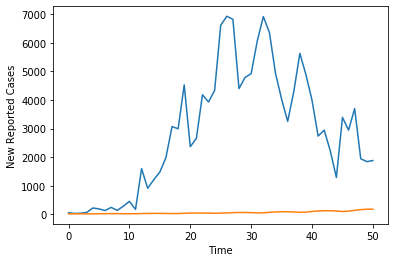

In [206]:
#create an array of times from t=0 to the end date
begin_date = date(2020,3,1)
end_date = date(2020,4,21)
num_days = end_date - begin_date
num_days = num_days.days

times = []
for i in range(0,num_days):
    times.append(i)

#data for Germany from 1/22/20 to 4/27/20
confirmedInfectedTotalData = [0,0,0,0,0,1,4,4,4,5,8,10,12,12,12,12,13,13,14,14,16,16,16,16,16,16,16,16,16,16,16,16,16,16,17,27,46,48,79,130,159,196,262,482,670,799,1040,1176,1457,1908,2078,3675,4585,5795,7272,9257,12327,15320,19848,22213,24873,29056,32986,37323,43938,50871,57695,62095,66885,71808,77872,84794,91159,96092,100123,103374,107663,113296,118181,122171,124908,127854,130072,131359,134753,137698,141397,143342,145184,147065,148291,150648,153129,154999,156513,157770,158758]
confirmedDeathsTotalData = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,3,3,7,9,11,17,24,28,44,67,84,94,123,157,206,267,342,433,533,645,775,920,1107,1275,1444,1584,1810,2016,2349,2607,2767,2736,3022,3194,3294,3804,4052,4352,4459,4586,4862,5033,5279,5575,5760,5877,5976,6126]
confirmedRecoveredTotalData = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,12,12,12,14,14,14,14,14,15,16,16,16,16,16,16,16,16,17,18,18,18,18,25,25,46,46,46,67,67,105,113,180,233,266,266,3243,3547,5673,6658,8481,9211,13500,16100,18700,22440,24575,26400,28700,28700,36081,46300,52407,53913,57400,60300,64300,68200,72600,77000,83114,85400,88000,91500,95200,99400,103300,109800,109800,112000,114500]

#select the correct range of values that correspond to the beginning and end date
begin_index = (begin_date - (date(2020,1,22))).days-1
end_index = (end_date - (date(2020,1,22))).days
confirmedInfectedSelectedData = confirmedInfectedTotalData[begin_index:end_index]

infectedReportedDifferences = np.diff(confirmedInfectedSelectedData)
values = np.asarray(infectedReportedDifferences)

# Run the same simulation using our new model wrapper

results = covidModel.simulate([0.6,0.35,11,36,0.25,0.2], times)
    
# Plot the results of the ODE + reporting delay eqn

plt.figure()
plt.xlabel('Time')
plt.ylabel('New Reported Cases')
plt.plot(times, values)
plt.plot(times, results)
plt.show()

problem = pints.SingleOutputProblem(covidModel, times, values)

We have the following list of parameters to be estimated:
$$
\theta = [ \lambda, \mu, D, I_0, f_w, \phi_w,\sigma]
$$

where \\(\sigma \\) is the scale width factor to the likelihood distribution. Below, we describe the likelihood for the data given the parameters, \\(p(\hat C| \theta)\\), as a Student-T distribution with 4 degrees of freedom.

In [164]:
class StudentTLogLikelihoodMultiplicative(pints.ProblemLogLikelihood):
    r"""
    Calculates a log-likelihood assuming independent Student-t-distributed
    noise at each time point, and adds two parameters: one representing the
    degrees of freedom (``nu``), the other representing the scale (``sigma``).

    For a noise characterised by ``nu'' and ``sigma``, the log likelihood is of
    the form:

    .. math::
        \log{L(\theta, \nu, \sigma|\boldsymbol{x})} =
            N\frac{\nu}{2}\log(\nu) - N\log(\sigma\sqrt{f(\theta)}) -
            N\log B(\nu/2, 1/2)
            -\frac{1+\nu}{2}\sum_{i=1}^N\log(\nu +
            \frac{x_i - f(\theta)}{\sigma\sqrt{f(\theta)}}^2)

    where ``B(.,.)`` is a beta function.

    Extends :class:`ProblemLogLikelihood`.

    Parameters
    ----------
    problem
        A :class:`SingleOutputProblem` or :class:`MultiOutputProblem`. For a
        single-output problem two parameters are added ``(nu, sigma)``, where
        ``nu`` is the degrees of freedom and ``sigma`` is scale, for a
        multi-output problem ``2 * n_outputs`` parameters are added.
    """

    def __init__(self, problem):
        super(StudentTLogLikelihoodMultiplicative, self).__init__(problem)

        # Get number of times, number of outputs
        self._nt = len(self._times)
        self._no = problem.n_outputs()

        # Add parameters to problem (two for each output)
        self._n_parameters = problem.n_parameters() + 2 * self._no

        # Pre-calculate
        self._n = len(self._times)

    def __call__(self, x):
        # For multiparameter problems the parameters are stored as
        # (model_params_1, model_params_2, ..., model_params_k,
        # nu_1, sigma_1, nu_2, sigma_2,...)
        n = self._n
        m = 2 * self._no

        # problem parameters
        problem_parameters = x[:-m]
        y = self._problem.evaluate(problem_parameters)
        error = self._values - y

        # Distribution parameters
        parameters = x[-m:]
        nu = np.asarray(parameters[0::2])
        sigma = np.asarray(parameters[1::2])

        # Calculate
        return np.sum(
            + 0.5 * n * nu * np.log(nu)
            - n * np.log(sigma * np.sqrt(y))
            - n * np.log(scipy.special.beta(0.5 * nu, 0.5))
            - 0.5 * (1 + nu) * np.sum(np.log(nu + (error / (sigma * np.sqrt(y)))**2), axis=0)
        )

class StudentTLogLikelihoodMultiplicative4(pints.ProblemLogLikelihood):
    r"""
    Calculates a log-likelihood assuming independent Student-t-distributed
    noise at each time point, and adds two parameters: one representing the
    degrees of freedom (``nu``), the other representing the scale (``sigma``).

    For a noise characterised by ``nu'' and ``sigma``, the log likelihood is of
    the form:

    .. math::
        \log{L(\theta, \sigma|\boldsymbol{x})} =
            N\frac{4}{2}\log(4) - N\log(\sigma\sqrt{f(\theta)}) -
            N\log B(4/2, 1/2)
            -\frac{1+4}{2}\sum_{i=1}^N\log(4 +
            \frac{x_i - f(\theta)}{\sigma\sqrt{f(\theta)}}^2)

    where ``B(.,.)`` is a beta function.

    Extends :class:`ProblemLogLikelihood`.

    Parameters
    ----------
    problem
        A :class:`SingleOutputProblem` or :class:`MultiOutputProblem`. For a
        single-output problem one parameter is added ``(sigma)``, where
        ``sigma`` is scale, for a multi-output problem ``n_outputs`` parameters are added.
    """

    def __init__(self, problem):
        super(StudentTLogLikelihoodMultiplicative4, self).__init__(problem)

        # Get number of times, number of outputs
        self._nt = len(self._times)
        self._no = problem.n_outputs()

        # Add parameters to problem (two for each output)
        self._n_parameters = problem.n_parameters() + self._no

        # Pre-calculate
        self._n = len(self._times)

    def __call__(self, x):
        # For multiparameter problems the parameters are stored as
        # (model_params_1, model_params_2, ..., model_params_k,
        # nu_1, sigma_1, nu_2, sigma_2,...)
        n = self._n
        m = self._no

        # problem parameters
        problem_parameters = x[:-m]
        y = self._problem.evaluate(problem_parameters)
        error = self._values - y

        # Distribution parameters
        parameters = x[-m:]
        sigma = np.asarray(parameters[0::2])
        nu = np.repeat(4, m)

        # Calculate
        return np.sum(
            + 0.5 * n * nu * np.log(nu)
            - n * np.log(sigma * np.sqrt(y))
            - n * np.log(scipy.special.beta(0.5 * nu, 0.5))
            - 0.5 * (1 + nu) * np.sum(np.log(nu + (error / (sigma * np.sqrt(y)))**2), axis=0)
        )
    
likelihood = StudentTLogLikelihoodMultiplicative4(problem)

Next, we define the prior distribution for each of the parameters to be estimated:

In [165]:
lamda_prior = pints.LogNormalLogPrior(math.log10(0.4),0.5) # lamda has Log-Normal prior
mu_prior = pints.LogNormalLogPrior(math.log10(1/8),0.2) # mu has Log-Normal prior
delay_prior = pints.LogNormalLogPrior(math.log10(8),0.2) # D has Log-Normal prior
initInfected_prior = pints.HalfCauchyLogPrior(0,100) # I0 has Half-Cauchy prior
scaleWidth_prior = pints.HalfCauchyLogPrior(0,10) # sigma has Half-Cauchy prior
fw_prior = pints.BetaLogPrior(0.7, 0.17) # f_w has Beta prior


#extend the pints.LogPrior class to describe the Von Mises prior
class VonMisesLogPrior (pints.LogPrior):
    def __init__(self, kappa):
        self._kappa = float(kappa)
        
    def n_parameters(self):
        return 1
        
    def __call__(self, angle):
         return vonmises.logpdf(angle,self._kappa,loc=0, scale=1)
        
        
phi_prior = VonMisesLogPrior(0.01) # phi_w has Von Mises prior

log_priors = pints.ComposedLogPrior(lamda_prior, mu_prior, delay_prior, initInfected_prior, scaleWidth_prior, fw_prior, phi_prior)

We define the posterior distribution, \\(p(\theta|\hat C )\\), below:

In [166]:
posterior = pints.LogPosterior(likelihood, log_priors)

Next, we create the MCMC sampling scheme, using the adaptive covariance method (Haario-Bardenet). According to the paper, we need to create 4 chains, perform 1000 burn-in steps, and sample for 4000 steps:

In [207]:
startingParamVals = [0.3, 0.13, 11, 36, 8, 0.6, 0.4]

xs = [
    np.array(startingParamVals) * 1.1,
    np.array(startingParamVals) * 1.05,
    np.array(startingParamVals) * 0.9,
    np.array(startingParamVals) * 1.15,
]

# Create mcmc routine with four chains
mcmc = pints.MCMCController(posterior, 4, xs, method=pints.HaarioBardenetACMC)

# Add stopping criterion
mcmc.set_max_iterations(4000)

# Start adapting after 1000 iterations
mcmc.set_initial_phase_iterations(1000)

chains = mcmc.run()

Using Haario-Bardenet adaptive covariance MCMC
Generating 4 chains.
Running in sequential mode.


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in sqrt


ValueError: Initial point for MCMC must have finite logpdf.